In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.compose import make_column_transformer
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv')
X_test = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv')

# drop rows without target in train data
df = df.dropna(axis=0, subset=['SalePrice'])

#split data into X and Y (target)
X = df.drop(['SalePrice'], axis=1)
Y = df.SalePrice # target

all_X = pd.concat([X, X_test], axis=0)



In [43]:
X.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [44]:
X.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [45]:
X.dtypes.value_counts()

object     43
int64      34
float64     3
dtype: int64

In [46]:
Y.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [47]:
Y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

#### Heatmap

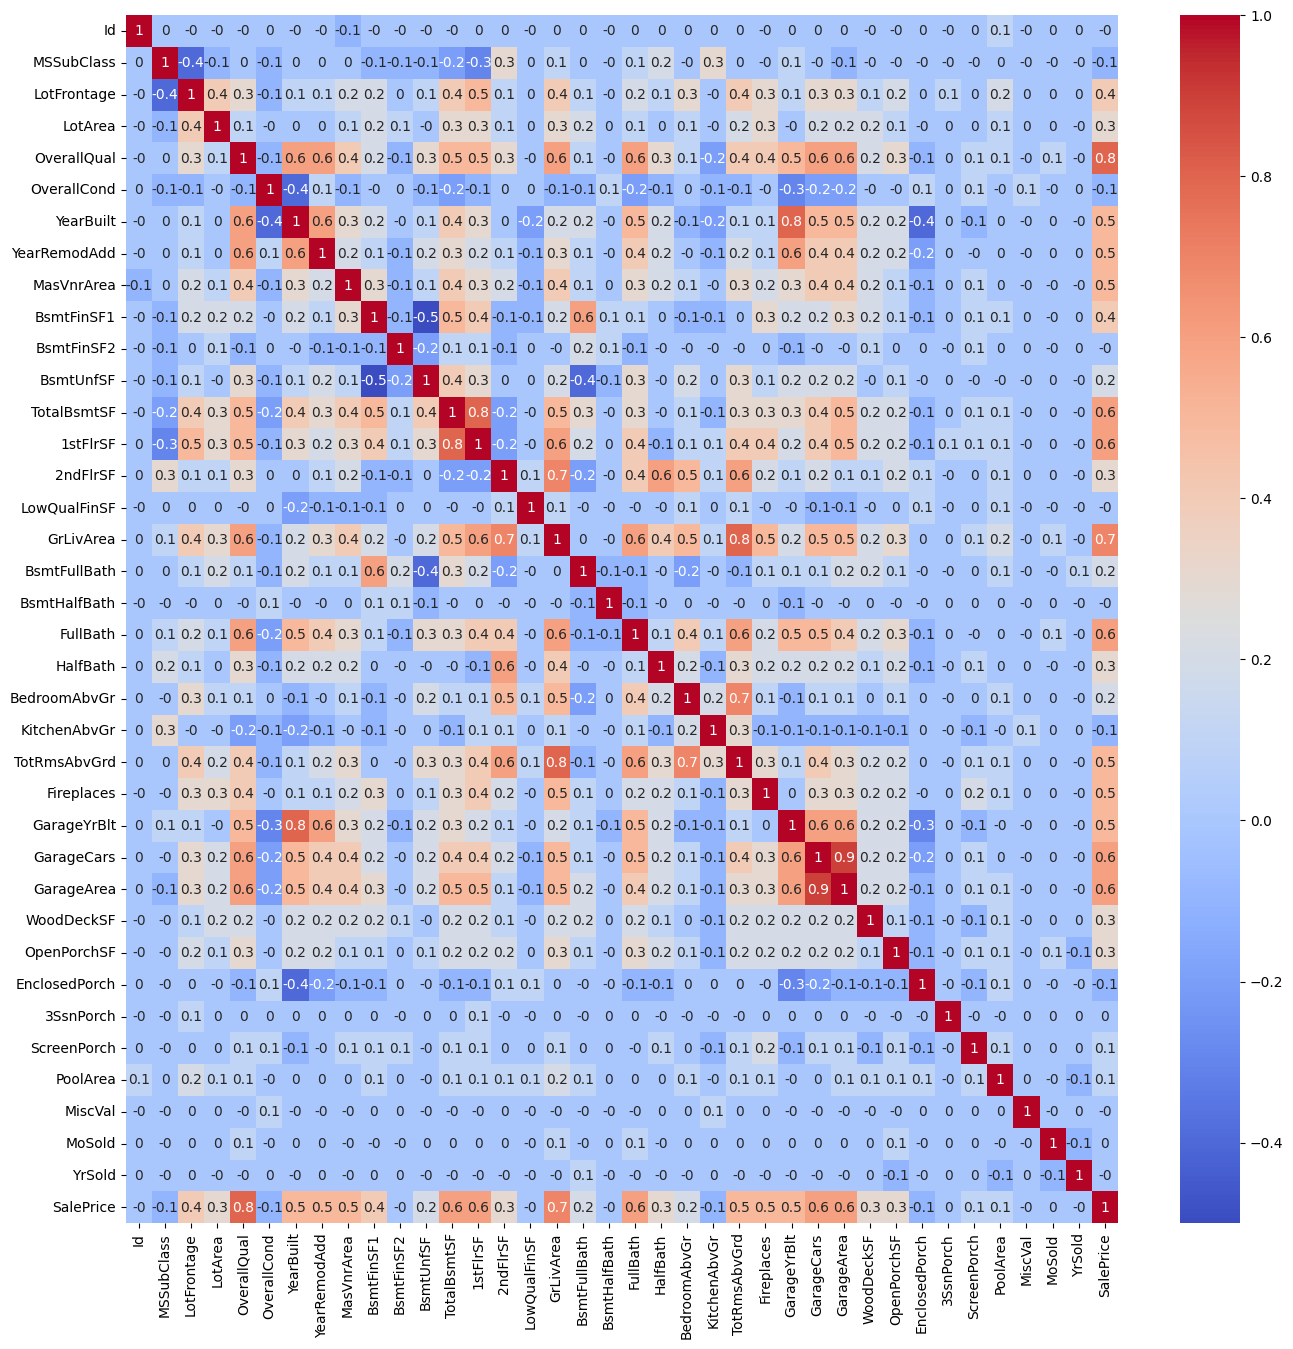

In [48]:
plt.figure(figsize = (16,16),dpi=100)
sns.heatmap(round(df.corr(),1),cmap='coolwarm',annot=True)
plt.show()

####  Variable Information 

In [49]:
cols = df.columns
num_cols = df._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))

#### Numeric Cols: 
        MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice
#### Categorical Cols: 
        'Foundation', 'Condition1', 'Exterior2nd', 'GarageFinish', 'LandSlope', 'KitchenQual', 'BldgType', 'PavedDrive', '    'GarageQual', 'GarageType', 'RoofMatl', 'FireplaceQu', 'LotShape', 'HouseStyle', 'BsmtCond', 'GarageCond', 'Neighborhood', 'Condition2', 'BsmtQual', 'MiscFeature', 'SaleType', 'BsmtFinType2', 'Exterior1st', 'LandContour', 'BsmtExposure', 'PoolQC', 'CentralAir', 'BsmtFinType1', 'Alley', 'Heating', 'HeatingQC', 'LotConfig', 'RoofStyle', 'Street', 'MasVnrType', 'ExterQual', 'MSZoning', 'Fence', 'Electrical', 'ExterCond', 'Utilities', 'Functional', 'SaleCondition'
        
        Categorical Columns will be encoded further down. 

#### Dealing with NaN Values

Will one-hot encode the categorical values (NaN = 0, else 1), and normalize the numeric values by imputing the mean.

In [50]:
null_values = X.isnull().sum()
null_values[null_values>0].sort_values()

Electrical         1
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
BsmtExposure      38
BsmtFinType2      38
GarageCond        81
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
LotFrontage      259
FireplaceQu      690
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64

In [51]:
all_X.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [52]:
null_col = [col for col in X.columns if X[col].isnull().sum() > 0]

def intersection(lst1, lst2):
    return list(set(lst1).intersection(lst2))

null_cats = intersection(null_col, cat_cols)
null_nums = intersection(null_col, num_cols)

all_X[null_cats[0]]

all_X.head()

all_X.MSSubClass


0        60
1        20
2        60
3        70
4        60
       ... 
1454    160
1455    160
1456     20
1457     85
1458     60
Name: MSSubClass, Length: 2919, dtype: int64

In [53]:

for col in null_cats:
    encoder = OneHotEncoder()
    encoder.fit(all_X[[Id, col]])
    all_X[str('Enc ' + category)] = encoder.transform(all_X[col])


NameError: name 'Id' is not defined

### Feature Encoding for Non-Nan Columns